# Step 1: multipage tif to 3D arrays in HDF5.
The images get in as multipage tiffs, where every page is a slice in the z-direction. I want to store all elements in a single h5 file

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.optimize import curve_fit
from scipy.optimize import OptimizeWarning
import warnings
warnings.filterwarnings("ignore", "overflow", RuntimeWarning)
warnings.filterwarnings("error", "Covariance", OptimizeWarning)

In [2]:
stacks_path = Path("../data/stacks")
paths = list(stacks_path.glob("*.tif"))

In [3]:
def get_strain_and_stress(sample_id: int):
    path = f"../data/curves/{sample_id}.csv"
    df = pd.read_csv(path)
    strain = df["strain"].to_numpy()
    stress = df["stress"].to_numpy()
    return np.stack([strain, stress])

In [4]:
def get_person_id(sample_id: int):
    path = "../data/targets.csv"
    df = pd.read_csv(path)
    return int(df[df["sample"] == sample_id]["person_id"].iloc[0])


In [5]:
def logistic(x, a, k, xc):
    return a / (1 + np.exp(-k * (x - xc)))

In [6]:
def fit_fun_to_data(fun, x, y):
    popt, _ = curve_fit(fun, x, y, maxfev=100000)
    return popt

In [7]:
def plot_to_make_sure(sample_id, popt):
    import matplotlib.pyplot as plt
    strain, stress = get_strain_and_stress(sample_id)
    plt.plot(strain, stress)
    x = np.linspace(1, 10, 100)
    plt.plot(x, logistic(x, *popt))
    plt.show()

OptimizeWarning for sample 15


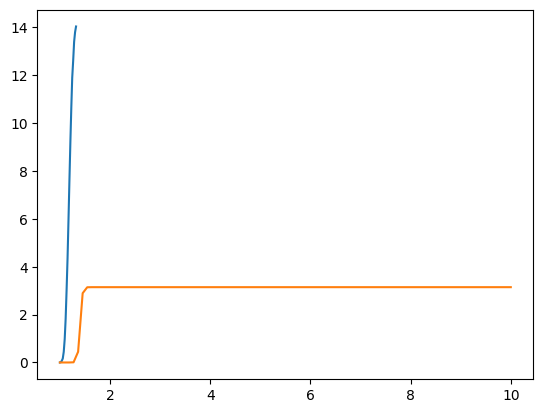

OptimizeWarning for sample 46


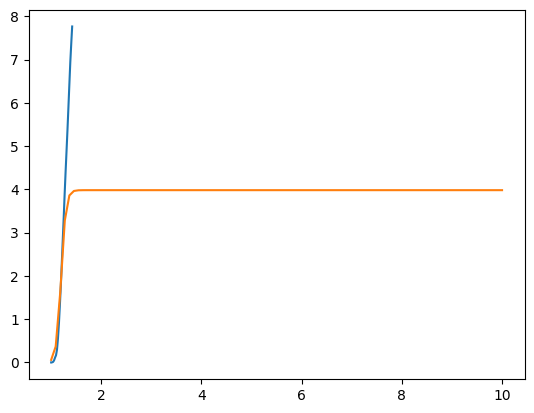

OptimizeWarning for sample 47


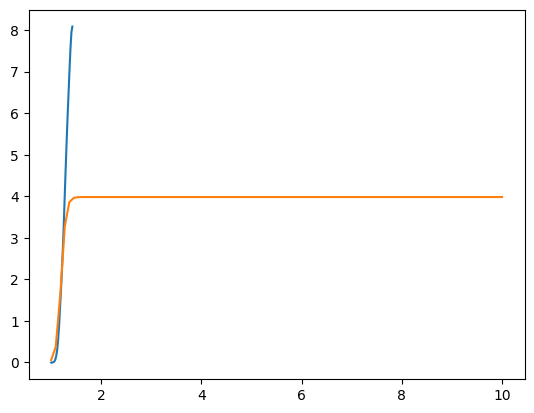

OptimizeWarning for sample 50


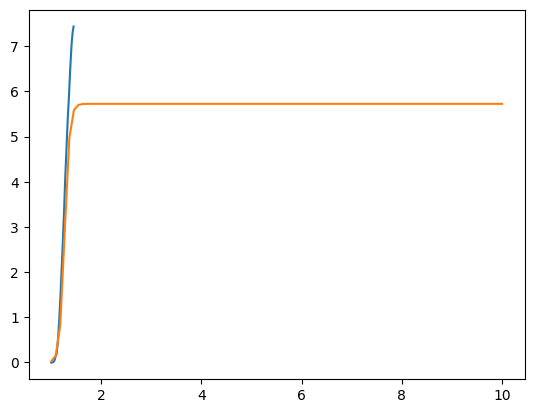

In [10]:
sample_ids = []
person_ids = []
strains, stresses = [], []
As, ks, xcs = [], [], []
for path in paths:
    try:
        sample_id = int(path.stem)
        person_id = get_person_id(sample_id)
        strain, stress = get_strain_and_stress(sample_id)
        a, k, xc = fit_fun_to_data(logistic, strain, stress)
    
    except OptimizeWarning:
        print(f"OptimizeWarning for sample {sample_id}")
        plot_to_make_sure(sample_id, [a, k, xc])
        continue
    except (FileNotFoundError, IndexError):
        continue
    else:
        sample_ids.append(sample_id)
        person_ids.append(person_id)
        strains.append(strain)
        stresses.append(stress)
        As.append(a)
        ks.append(k)
        xcs.append(xc)


In [11]:
pd.DataFrame({"sample_id": sample_ids, "A": As, "k": ks, "xc": xcs}).to_csv("../data/params.csv", index=False)
pd.DataFrame({"sample_id": sample_ids, "person_id": person_ids}).to_csv("../data/sample_to_person.csv", index=False)

# Step 2: Make splits

In [12]:
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, GroupKFold

In [13]:
gss = GroupShuffleSplit(1, random_state=42)
gkf = GroupKFold(5)

df = pd.read_csv("../data/sample_to_person.csv")
train_super_idx, test_idx = next(gss.split(df, groups=df["person_id"]))


k = 0
list(gkf.split(dataset.indices, groups=[sample["0/person_id"] for sample in dataset]))[k]
# for train_idx, val_idx in gkf.split(dataset.indices, groups=[sample["0/person_id"] for sample in dataset]):
    # print(train_idx, val_idx)
dataset.close()

NameError: name 'h5torch' is not defined

In [81]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    import matplotlib.pyplot as plt
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        cmap_cv = plt.cm.coolwarm

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    cmap_data = plt.cm.Paired

    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["group"]
    ax.set(
        yticks=np.arange(n_splits + 1) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 1.2, -0.2],
        xlim=[0, len(y)],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

<Axes: title={'center': 'GroupKFold'}, xlabel='Sample index', ylabel='CV iteration'>

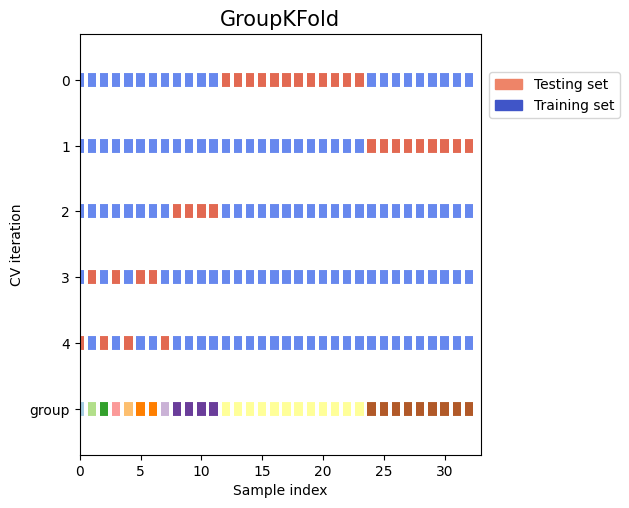

In [68]:
import matplotlib.pyplot as plt
cmap_cv = plt.cm.coolwarm
from matplotlib.patches import Patch
fig, ax = plt.subplots()
dataset = h5torch.Dataset(out_path, subset=train_super_idx)
ax.legend(
    [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
    ["Testing set", "Training set"],
    loc=(1.02, 0.8),
)
# Make the legend fit
plt.tight_layout()
fig.subplots_adjust(right=0.7)
plot_cv_indices(gkf, dataset.indices, dataset.indices, [sample["0/person_id"] for sample in dataset], ax, 5)